# Predicting Time to Merge of a Pull Request

One of the machine learning explorations within the OpenShift CI Analysis project is predicting time to merge of a pull request (see this [issue](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/236) for more details). In a previous [notebook](../data-sources/oc-github-repo/github_PR_EDA.ipynb) we showed how to access the PR data for the [openshift/origin](https://github.com/openshift/origin) repo, and then performed initial data analysis as well as feature engineering on it. Furthermore, we also split the `time_to_merge` values for the PRs into the following 10 discrete, equally populated bins, so that this task becomes a classification problem:

Class 0 : < 3 hrs  
Class 1 : < 6 hrs  
Class 2 : < 15 hrs  
Class 3 : < 24 hrs / 1 day  
Class 4 : < 36 hrs / 1.5 days  
Class 5 : < 60 hrs / 2.5 days  
Class 6 : < 112 hrs / ~4.5 days  
Class 7 : < 190 hrs / ~8 days  
Class 8 : < 462 hrs / ~19 days  
Class 9: > 462 hrs  

In this notebook, we will first create transformer objects (based on the explorations in the previous notebook) to extract features from raw PR data. Then, we will train machine learning models to classify a PR's `time_to_merge` into one of the above 10 bins (or "classes").

In [1]:
import os
import gzip
import json
import tempfile
import boto3

import joblib
import warnings
from io import BytesIO
from copy import deepcopy

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder

from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from dotenv import load_dotenv, find_dotenv

from src.features.build_features import (
    IsUserPrivTransformer,
    DateTimeDetailsTransformer,
    ChangeInDirTransformer,
    NumChangedFilesTransformer,
    StringLenTransformer,
    NumPrevPRsTransformer,
    FileTypeCountTransformer,
    TitleWordCountTransformer,
)

In [ ]:
class CephCommunication:
    """
    Class to establish communication with a ceph s3 bucket.
    It connects with the bucket and provides methods to read and write data in the parquet format.
    """

    def __init__(
        self, s3_endpoint_url, aws_access_key_id, aws_secret_access_key, s3_bucket
    ):
        self.s3_endpoint_url = s3_endpoint_url
        self.aws_access_key_id = aws_access_key_id
        self.aws_secret_access_key = aws_secret_access_key
        self.s3_resource = boto3.resource(
            "s3",
            endpoint_url=self.s3_endpoint_url,
            aws_access_key_id=self.aws_access_key_id,
            aws_secret_access_key=self.aws_secret_access_key,
        )
        self.bucket = s3_bucket
        ## Todo: Add try catch

    def upload_to_ceph(self, dataframe, s3_path, filename):
        """
        This helper function takes as input the data frame to be uploaded, and the output filename.
        It then saves the data frame in the defined ceph bucket.
        """
        parquet_buffer = BytesIO()
        dataframe.to_parquet(parquet_buffer)
        s3_obj = self.s3_resource.Object(self.bucket, f"{s3_path}/{filename}")
        status = s3_obj.put(Body=parquet_buffer.getvalue())
        return status

    def read_from_ceph(self, s3_path, filename):
        """
        Helper function to read from ceph and see if the saved data is correct.
        """
        buffer = BytesIO()
        s3_object = self.s3_resource.Object(self.bucket, f"{s3_path}/{filename}")
        s3_object.download_fileobj(buffer)
        df_temp = pd.read_parquet(buffer)
        return df_temp

In [2]:
warnings.filterwarnings("ignore")
load_dotenv(find_dotenv())

True

## Get Raw Data

In [3]:
## CEPH Bucket variables
## Create a .env file on your local with the correct configs,
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_path = "github"
REMOTE = os.getenv("REMOTE")
AUTOMATION = os.getenv("AUTOMATION")
data_path = "../../data/raw/GitHub/PullRequest.json.gz"

In [4]:
if REMOTE:
    print("getting dataset from ceph")
    s3 = boto3.resource(
        "s3",
        endpoint_url=s3_endpoint_url,
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
    )
    content = s3.Object(s3_bucket, "thoth/mi/openshift/origin/PullRequest.json")
    file = content.get()["Body"].read().decode("utf-8")
    prs = json.loads(file)

    if not AUTOMATION:
        with gzip.open(data_path, "wb") as out_file:
            out_file.write(json.dumps(prs).encode("utf-8"))

else:
    print("getting dataset from local")
    with gzip.open(data_path, "r") as f:
        prs = json.loads(f.read().decode("utf-8"))

pr_df = pd.DataFrame(prs).T

getting dataset from ceph


## Extract Labels from Raw Data

In [5]:
def get_ttm_class(ttm):
    """
    Assign a ttm "class" / "category" / "bin" to the input numerical ttm value
    E.g. if the time to merge was 1.5 hours, this function will return
    class "0" which represents "merged in 0-3 hours"
    """
    if ttm < 3:
        return 0
    elif ttm < 6:
        return 1
    elif ttm < 15:
        return 2
    elif ttm < 24:
        return 3
    elif ttm < 36:
        return 4
    elif ttm < 60:
        return 5
    elif ttm < 112:
        return 6
    elif ttm < 190:
        return 7
    elif ttm < 462:
        return 8
    else:
        return 9


y = (pr_df["merged_at"] - pr_df["created_at"]).astype("float")
y = y.dropna()
y = (y / 3600).apply(get_ttm_class)
y.head()

26100    5
26099    2
26096    3
26092    5
26091    5
dtype: int64

## Extract Features from Raw Data

In this section, we will create transformer objects to process raw data as per the feature extraction methods that were found to be the most effective in the previous EDA notebook.

To ensure that joblib serializes the custom transformer objects correctly, we will write their definitions in [`src/features/build_features.py`](../../src/features/build_features.py) instead of this notebook, and import them from the `src` package. This way, the `src` package can be listed as a dependency wherever these objects need to be deserialized (for example, Seldon server).

#### size

In [6]:
# map values to 0,1,2,3,4,5
pr_size_encoder = OrdinalEncoder(categories=[["XS", "S", "M", "L", "XL", "XXL"]])

#### is_approver / is_reviewer

In [7]:
# check if pr is created by approvers / reviewers / other privileged users
is_reviewer_transf = IsUserPrivTransformer(priv="reviewers")
is_approver_transf = IsUserPrivTransformer(priv="approvers")

#### created_at

In [8]:
# get day, month, date, etc. from a unix timestamp
dt_details_transf = DateTimeDetailsTransformer()

#### change_in_\<dir\>

In [9]:
# determine if PR made changes in some specific directories in repo
DIRS_TO_CHECK = [
    ".github",
    "docs",
    "pkg",
    "test",
    "vendor",
    "root",
]
change_in_dirs_transf = ChangeInDirTransformer(dirs_to_check=DIRS_TO_CHECK)

#### changed_files_number

In [10]:
# number of files changed in PR
n_changed_files_transf = NumChangedFilesTransformer()

#### body_size

In [11]:
# number of characters in PR description
body_size_transf = StringLenTransformer("body")

#### num_previous_merged_prs

In [12]:
# number of PRs that the creator of this PR has previously contributed
n_prev_prs_transf = NumPrevPRsTransformer()

#### filetype_\<type>

In [13]:
# how many files of the given extension were changed in PR
FILE_EXTENSIONS_TO_COUNT = [
    ".1",
    ".adoc",
    ".bash",
    ".bats",
    ".c",
    ".centos7",
    ".cert",
    ".conf",
    ".crt",
    ".empty",
    ".feature",
    ".files_generated_oc",
    ".files_generated_openshift",
    ".gitattributes",
    ".gitignore",
    ".go",
    ".gz",
    ".html",
    ".ini",
    ".json",
    ".key",
    ".mailmap",
    ".markdown",
    ".md",
    ".mk",
    ".mod",
    ".pl",
    ".proto",
    ".rhel",
    ".s",
    ".sec",
    ".service",
    ".sh",
    ".signature",
    ".spec",
    ".sum",
    ".sysconfig",
    ".template",
    ".txt",
    ".xml",
    ".yaml",
    ".yaml-merge-patch",
    ".yml",
    "AUTHORS",
    "BUILD",
    "CONTRIBUTORS",
    "Dockerfile",
    "LICENSE",
    "MAINTAINERS",
    "Makefile",
    "NOTICE",
    "PATENTS",
    "README",
    "Readme",
    "VERSION",
    "Vagrantfile",
    "cert",
    "key",
    "oadm",
    "oc",
    "openshift",
    "result",
    "run",
    "test",
]

ftype_count_transf = FileTypeCountTransformer(file_extensions=FILE_EXTENSIONS_TO_COUNT)

#### title_wordcount_\<word>

In [14]:
# how many times these words appeared in PR title
WORDS_TO_COUNT = [
    "add",
    "bug",
    "bump",
    "diagnostics",
    "disable",
    "fix",
    "haproxy",
    "oc",
    "publishing",
    "revert",
    "router",
    "sh",
    "staging",
    "support",
    "travis",
]

title_wc_transf = TitleWordCountTransformer(words=WORDS_TO_COUNT)

## Apply Transforms

In [15]:
# FIXME: breaks if not sorted. can we shave off some runtime by not requiring to sort?
pr_df = pr_df.sort_values(by="created_at")

In [16]:
# transformer objects compiled into one columntransformer
raw_data_processor = ColumnTransformer(
    [
        ("pr_size", pr_size_encoder, ["size"]),  # 1 cols generated
        ("is_reviewer", is_reviewer_transf, ["created_by"]),  # 1 cols generated
        ("is_approver", is_approver_transf, ["created_by"]),  # 1 cols generated
        ("created_at_details", dt_details_transf, ["created_at"]),  # 4 cols generated
        ("change_dirs", change_in_dirs_transf, ["changed_files"]),  # 6 cols generated
        (
            "n_changed_files",
            n_changed_files_transf,
            ["changed_files_number"],
        ),  # 1 cols generated
        ("body_size", body_size_transf, ["body"]),  # 1 cols generated
        ("n_prev_prs", n_prev_prs_transf, ["created_by"]),  # 1 cols generated
        ("n_commits", "passthrough", ["commits_number"]),  # 1 cols generated
        (
            "filetype_counter",
            ftype_count_transf,
            ["changed_files"],
        ),  # 64 cols generated
        ("title_word_counter", title_wc_transf, ["title"]),  # 15 cols generated
    ],
    remainder="drop",
)

In [17]:
# column names. this is needed because sklearn forcefully converts df to ndarray,
# thus losing column information. this is a hack to retain that info. look for alternatives
cols = (
    [
        "size",
        "is_reviewer",
        "is_approver",
        "created_at_day",
        "created_at_month",
        "created_at_weekday",
        "created_at_hour",
    ]
    + [f"change_in_{d}" for d in DIRS_TO_CHECK]
    + [
        "changed_files_number",
        "body_size",
        "num_prev_merged_prs",
        "commits_number",
    ]
    + [f"filetype_{f}" for f in FILE_EXTENSIONS_TO_COUNT]
    + [f"title_wordcount_{w}" for w in WORDS_TO_COUNT]
)

In [18]:
X = raw_data_processor.fit_transform(pr_df)
X = pd.DataFrame(X, index=pr_df.index, columns=cols)
X.head()

,size,is_reviewer,is_approver,created_at_day,created_at_month,created_at_weekday,created_at_hour,change_in_.github,change_in_docs,change_in_pkg,...,title_wordcount_fix,title_wordcount_haproxy,title_wordcount_oc,title_wordcount_publishing,title_wordcount_revert,title_wordcount_router,title_wordcount_sh,title_wordcount_staging,title_wordcount_support,title_wordcount_travis
1,0.0,False,False,11,8,0,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5.0,False,False,12,8,1,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,False,True,12,8,1,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,False,True,12,8,1,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2.0,False,False,12,8,1,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Drop NA + Train/Test Split

In [19]:
# drop entries for which labels are unknown
# also make sure labels and features are consistent
X = X.reindex(y.index)

In [20]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [21]:
# upload X_test and y_test to S3 bucket for testing / running sanity check on the model inference service
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)

ret = cc.upload_to_ceph(X_test, s3_path, "X_test.parquet")
print(ret["ResponseMetadata"]["HTTPStatusCode"])

ret = cc.upload_to_ceph(y_test.to_frame("ttm_class"), s3_path, "y_test.parquet")
print(ret["ResponseMetadata"]["HTTPStatusCode"])

200
200


In [22]:
# convert from pandas series to lists to avoid warnings during training
y_train = y_train.to_list()
y_test = y_test.to_list()

## Scale data

In [23]:
# lets apply a yeo johnson transform to try to make the data more gaussian
scaler = PowerTransformer()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Define Training and Evaluation Pipeline

Here, we will define a function to train a given classifier on the training set and then evaluate it on the test set. 

In [24]:
def train_evaluate_classifier(clf, xtrain, ytrain, xtest, ytest):
    # Train our classifier
    clf.fit(xtrain, ytrain)

    # Make predictions
    preds = clf.predict(xtest)

    # View classification report
    print(classification_report(ytest, preds))

    # Plot confusion matrix heatmap
    plt.figure(figsize=(16, 12))
    cf_matrix = confusion_matrix(ytest, preds)
    group_counts = ["{0:0.0f}\n".format(value) for value in cf_matrix.flatten()]
    group_percentages = [
        "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
    ]
    box_labels = [
        f"{v1}{v2}".strip() for v1, v2 in zip(group_counts, group_percentages)
    ]
    box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])

    sns.heatmap(cf_matrix, cmap="OrRd", annot=box_labels, fmt="")
    plt.xlabel("Predicted TTM Label")
    plt.ylabel("True TTM Label")
    plt.title("Confusion Matrix Heatmap")

## Define Models and Parameters

Next, we will define and initialize the classifiers that we will be exploring for the time-to-merge prediction task.

### Gaussian Naive Bayes

In [25]:
# Initialize classifier
gnb = GaussianNB()

### SVM

In [26]:
# Initialize classifier
svc = SVC(random_state=42)

### Random Forest

In [27]:
# Initialize classifier
rf = RandomForestClassifier(
    n_estimators=200,
    max_features=0.75,
    random_state=42,
    n_jobs=-1,
)

### XGBoost

In [28]:
# Initialize classifier
xgbc = XGBClassifier(
    n_estimators=125,
    learning_rate=0.1,
    random_state=42,
    verbosity=1,
    n_jobs=-1,
)

## Compare Model Results

Finally, we will run the train all of the classifiers defined above and evaluate their performance. 

### Train using all features

First, lets train the classifiers using all the engineered features as input.

              precision    recall  f1-score   support

           0       0.16      0.08      0.10       257
           1       0.08      0.94      0.15       214
           2       0.00      0.00      0.00       327
           3       0.17      0.02      0.03       275
           4       0.00      0.00      0.00       263
           5       0.12      0.00      0.01       234
           6       0.50      0.00      0.01       284
           7       0.25      0.00      0.01       281
           8       0.50      0.01      0.03       294
           9       0.21      0.07      0.11       277

    accuracy                           0.09      2706
   macro avg       0.20      0.11      0.04      2706
weighted avg       0.20      0.09      0.04      2706



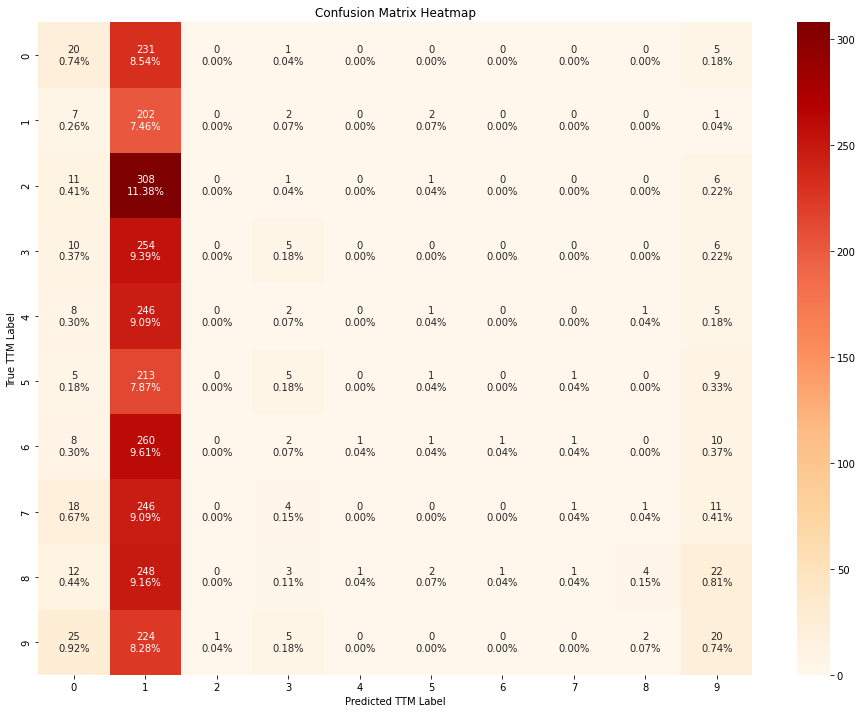

In [29]:
train_evaluate_classifier(gnb, X_train_scaled, y_train, X_test_scaled, y_test)

              precision    recall  f1-score   support

           0       0.29      0.43      0.35       257
           1       0.14      0.00      0.01       214
           2       0.19      0.48      0.27       327
           3       0.15      0.07      0.09       275
           4       0.16      0.06      0.09       263
           5       0.10      0.04      0.06       234
           6       0.17      0.29      0.21       284
           7       0.21      0.08      0.12       281
           8       0.22      0.17      0.20       294
           9       0.22      0.27      0.25       277

    accuracy                           0.20      2706
   macro avg       0.19      0.19      0.16      2706
weighted avg       0.19      0.20      0.17      2706



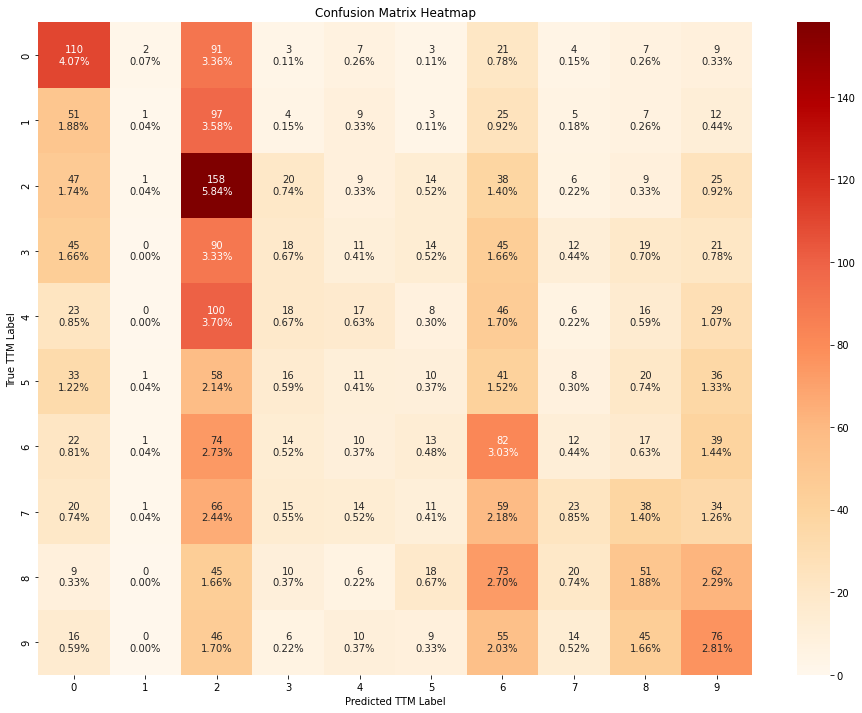

In [30]:
train_evaluate_classifier(svc, X_train_scaled, y_train, X_test_scaled, y_test)

              precision    recall  f1-score   support

           0       0.31      0.41      0.35       257
           1       0.14      0.07      0.10       214
           2       0.18      0.24      0.20       327
           3       0.20      0.20      0.20       275
           4       0.19      0.15      0.16       263
           5       0.13      0.10      0.11       234
           6       0.23      0.31      0.26       284
           7       0.18      0.15      0.16       281
           8       0.19      0.15      0.17       294
           9       0.25      0.27      0.26       277

    accuracy                           0.21      2706
   macro avg       0.20      0.20      0.20      2706
weighted avg       0.20      0.21      0.20      2706



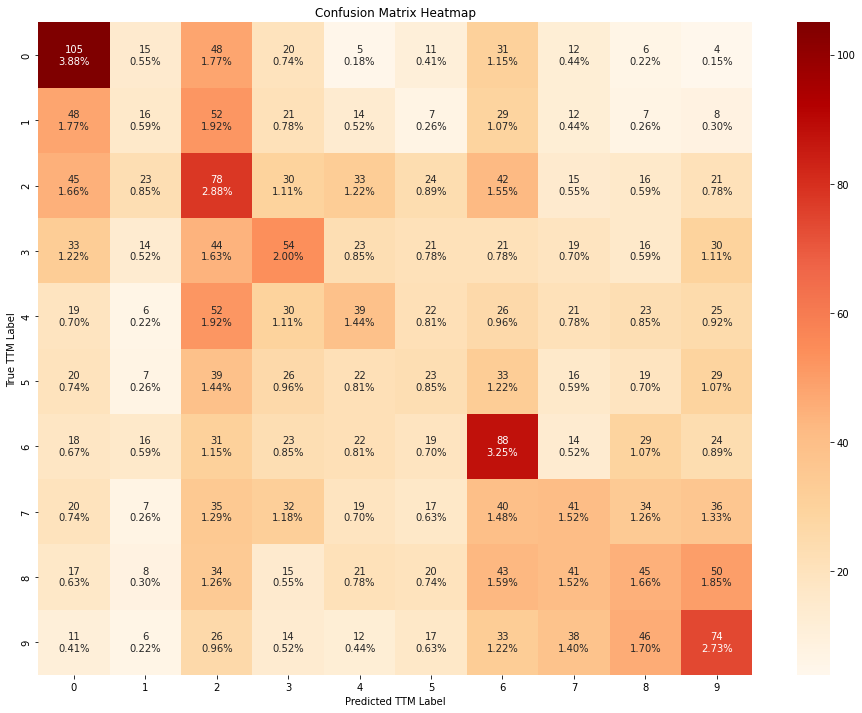

In [31]:
train_evaluate_classifier(rf, X_train_scaled, y_train, X_test_scaled, y_test)

[15:17:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.34      0.47      0.39       257
           1       0.13      0.07      0.09       214
           2       0.19      0.28      0.23       327
           3       0.17      0.16      0.16       275
           4       0.13      0.10      0.11       263
           5       0.12      0.09      0.10       234
           6       0.24      0.31      0.27       284
           7       0.15      0.13      0.14       281
           8       0.25      0.21      0.23       294
           9       0.27      0.28      0.27       277

    accuracy                           0.21      2706
   macro avg       0.20      0.21      0.20      2706
weighted avg       0.20      0.21      0.20

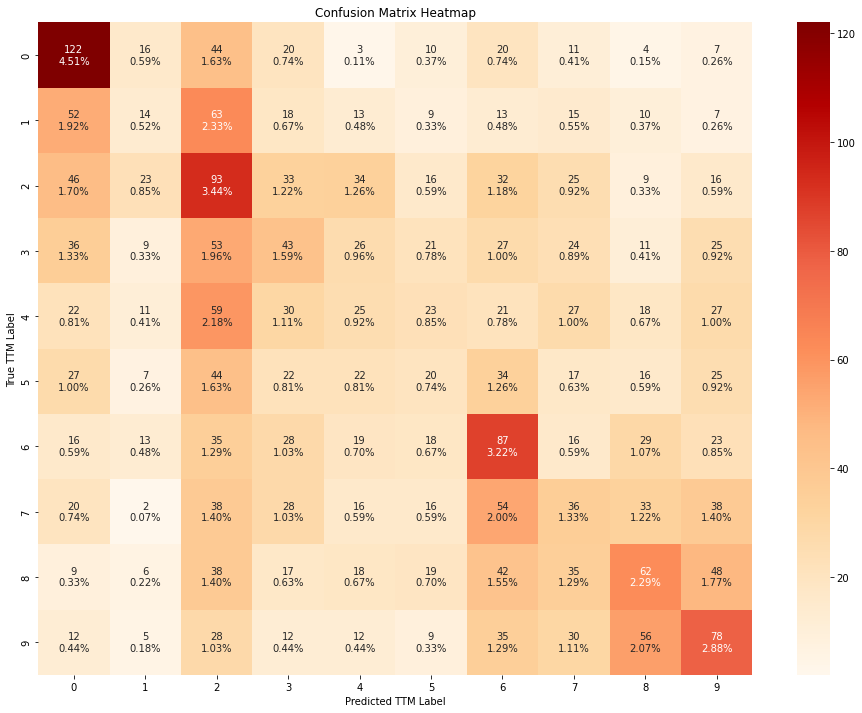

In [32]:
train_evaluate_classifier(xgbc, X_train_scaled, y_train, X_test_scaled, y_test)

Based on the results above, it seems like all the models outperform a random guess. The XGBoost classifier outperforms all others, followed closely by random forest. Furthermore, the Naive bayes and SVM models seem to be heavily biased towards a few classes. On the contrary, the random forest andthe  XGBoost models seem to be less biased and have mis-classifications within the bordering classes amongst the ordinal classes.

Note that for model deployment (which is the eventual goal), we will also need to include any scaler or preprocessor objects. This is because the input to the inference service will be raw unscaled data. We plan to address this issue by using `sklearn.Pipeline` object to package the preprocessor(s) and model as one "combined" model. Since an XGBoost model baked into an sklearn.Pipeline object might be complicated to serve on a seldon sklearn server, and since random forest performs almost as well as xgboost, we will save the random forest as the "best" model here. In the step below, we create a copy of the model so that we can save it to S3 later on and use it for model deployment.

In [33]:
# create a clone (create a copy of the object with the learned weights)
selected_model = deepcopy(rf)

In [34]:
# sanity check
print(classification_report(y_test, selected_model.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.31      0.41      0.35       257
           1       0.14      0.07      0.10       214
           2       0.18      0.24      0.20       327
           3       0.20      0.20      0.20       275
           4       0.19      0.15      0.16       263
           5       0.13      0.10      0.11       234
           6       0.23      0.31      0.26       284
           7       0.18      0.15      0.16       281
           8       0.19      0.15      0.17       294
           9       0.25      0.27      0.26       277

    accuracy                           0.21      2706
   macro avg       0.20      0.20      0.20      2706
weighted avg       0.20      0.21      0.20      2706



### Train using pruned features

In the previous notebook we performed some feature engineering and pruned the number of features down to 96. However, it might be possible that further pruning the features based on the importances given to them by the models yields more generalizable and accurate models. So in this section, we will explore using Recursive Feature Elimination (RFE) to rank the features in terms of their importance, and recursively select the best subsets to train our models with.

In [35]:
# use the xgboost classifier as the base estimator since it had the highest f1
selector = RFE(xgbc, n_features_to_select=20, step=5)
selector = selector.fit(X_train_scaled, y_train)

[15:17:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:18:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

In [36]:
# No of top features to select
top = 20

In [37]:
ranks = selector.ranking_
ranks

array([ 1,  1,  1,  4,  3,  1,  1, 15,  5,  1,  1,  1,  6,  1,  1,  1,  4,
        8,  4, 11, 15, 13, 12, 17,  7,  1, 17, 16, 12,  6, 15,  9,  1, 13,
        1, 16,  5, 13, 10, 14,  6, 14, 10, 16,  7, 11,  8, 15, 10,  7, 16,
        8, 11, 15,  5, 10, 12,  3, 13,  7, 14,  5, 12,  8,  6, 11,  6,  9,
       10, 14, 13,  9,  3, 16, 17,  9,  1,  1, 17, 17, 14,  5,  1,  1,  8,
        4,  3, 11,  1,  7,  1,  2,  4,  9,  3, 12])

In [38]:
cols = X_train.columns.to_numpy()
cols

array(['size', 'is_reviewer', 'is_approver', 'created_at_day',
       'created_at_month', 'created_at_weekday', 'created_at_hour',
       'change_in_.github', 'change_in_docs', 'change_in_pkg',
       'change_in_test', 'change_in_vendor', 'change_in_root',
       'changed_files_number', 'body_size', 'num_prev_merged_prs',
       'commits_number', 'filetype_.1', 'filetype_.adoc',
       'filetype_.bash', 'filetype_.bats', 'filetype_.c',
       'filetype_.centos7', 'filetype_.cert', 'filetype_.conf',
       'filetype_.crt', 'filetype_.empty', 'filetype_.feature',
       'filetype_.files_generated_oc',
       'filetype_.files_generated_openshift', 'filetype_.gitattributes',
       'filetype_.gitignore', 'filetype_.go', 'filetype_.gz',
       'filetype_.html', 'filetype_.ini', 'filetype_.json',
       'filetype_.key', 'filetype_.mailmap', 'filetype_.markdown',
       'filetype_.md', 'filetype_.mk', 'filetype_.mod', 'filetype_.pl',
       'filetype_.proto', 'filetype_.rhel', 'filetype_.s',


In [39]:
indices_by_ranks = ranks.argsort()
indices_by_ranks

array([ 0, 76, 77, 82, 83, 34, 88, 25, 90, 15, 14, 13, 32, 11,  2,  6,  1,
        5,  9, 10, 91, 57,  4, 94, 86, 72, 18, 92, 16,  3, 85, 54, 36, 61,
       81,  8, 64, 29, 66, 12, 40, 49, 24, 44, 59, 89, 46, 17, 63, 84, 51,
       71, 67, 75, 93, 31, 48, 55, 68, 42, 38, 45, 19, 87, 52, 65, 95, 56,
       22, 28, 62, 58, 21, 70, 33, 37, 60, 80, 39, 41, 69, 47,  7, 20, 53,
       30, 27, 35, 50, 43, 73, 78, 26, 23, 74, 79])

In [40]:
sorted_ranks = ranks[indices_by_ranks]
sorted_ranks

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,
        5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12,
       12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15,
       15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17])

In [41]:
cols_by_rank = cols[indices_by_ranks]
cols_by_rank[:top]

array(['size', 'filetype_oc', 'filetype_openshift', 'title_wordcount_bug',
       'title_wordcount_bump', 'filetype_.html', 'title_wordcount_oc',
       'filetype_.crt', 'title_wordcount_revert', 'num_prev_merged_prs',
       'body_size', 'changed_files_number', 'filetype_.go',
       'change_in_vendor', 'is_approver', 'created_at_hour',
       'is_reviewer', 'created_at_weekday', 'change_in_pkg',
       'change_in_test'], dtype=object)

In [42]:
# prune the training set
X_train_scaled_pruned = X_train_scaled[:, selector.support_]
X_test_scaled_pruned = X_test_scaled[:, selector.support_]

              precision    recall  f1-score   support

           0       0.10      0.97      0.19       257
           1       0.00      0.00      0.00       214
           2       0.14      0.01      0.01       327
           3       0.00      0.00      0.00       275
           4       0.00      0.00      0.00       263
           5       0.05      0.00      0.01       234
           6       0.12      0.01      0.02       284
           7       0.00      0.00      0.00       281
           8       0.00      0.00      0.00       294
           9       0.19      0.17      0.18       277

    accuracy                           0.11      2706
   macro avg       0.06      0.12      0.04      2706
weighted avg       0.06      0.11      0.04      2706



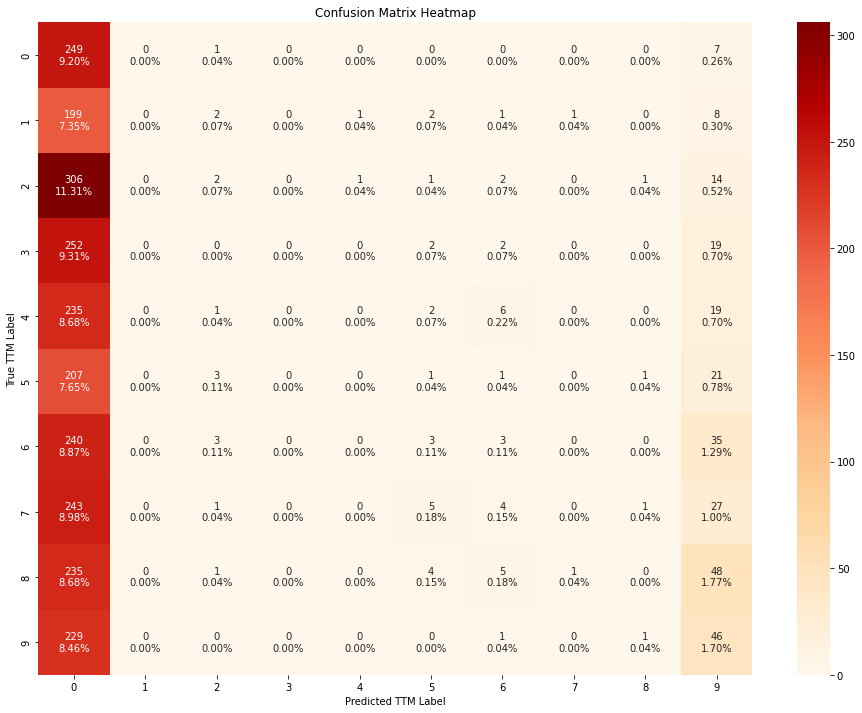

In [43]:
train_evaluate_classifier(
    gnb, X_train_scaled_pruned, y_train, X_test_scaled_pruned, y_test
)

              precision    recall  f1-score   support

           0       0.29      0.50      0.37       257
           1       0.09      0.01      0.02       214
           2       0.19      0.40      0.26       327
           3       0.18      0.13      0.15       275
           4       0.17      0.10      0.12       263
           5       0.12      0.05      0.07       234
           6       0.21      0.27      0.24       284
           7       0.15      0.11      0.13       281
           8       0.19      0.14      0.16       294
           9       0.24      0.28      0.26       277

    accuracy                           0.21      2706
   macro avg       0.18      0.20      0.18      2706
weighted avg       0.19      0.21      0.18      2706



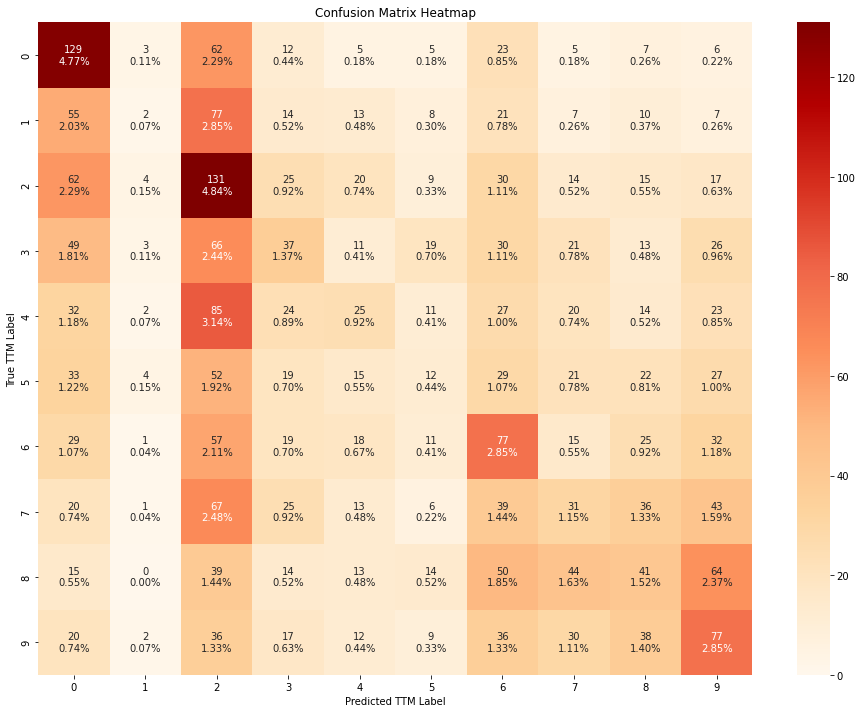

In [44]:
train_evaluate_classifier(
    svc, X_train_scaled_pruned, y_train, X_test_scaled_pruned, y_test
)

              precision    recall  f1-score   support

           0       0.27      0.36      0.31       257
           1       0.13      0.08      0.10       214
           2       0.20      0.24      0.22       327
           3       0.20      0.17      0.19       275
           4       0.16      0.14      0.15       263
           5       0.10      0.09      0.09       234
           6       0.23      0.30      0.26       284
           7       0.15      0.13      0.14       281
           8       0.21      0.20      0.20       294
           9       0.24      0.23      0.24       277

    accuracy                           0.20      2706
   macro avg       0.19      0.19      0.19      2706
weighted avg       0.19      0.20      0.19      2706



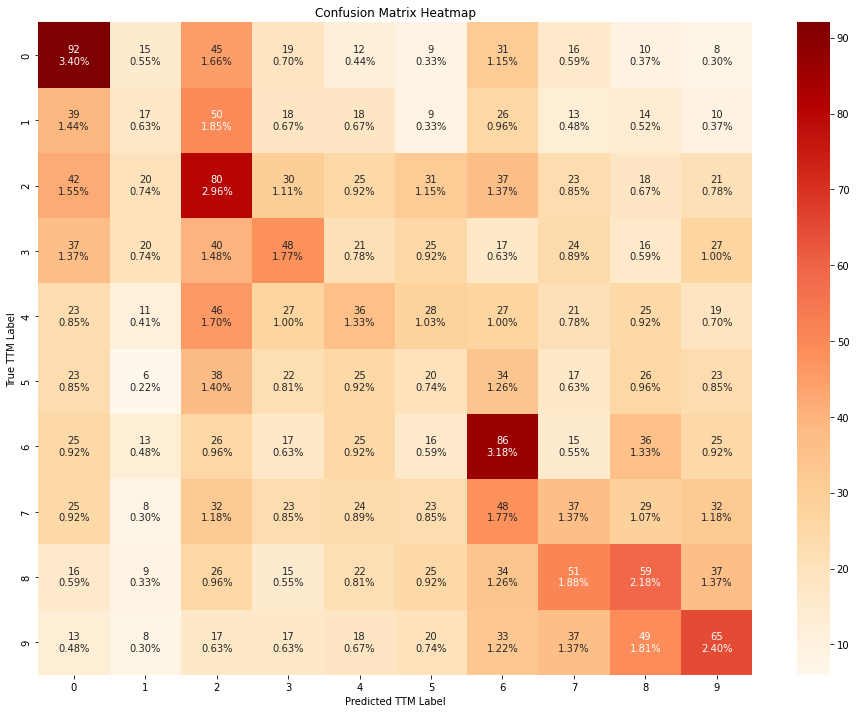

In [45]:
train_evaluate_classifier(
    rf, X_train_scaled_pruned, y_train, X_test_scaled_pruned, y_test
)

[15:21:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.28      0.39      0.33       257
           1       0.20      0.10      0.13       214
           2       0.19      0.28      0.23       327
           3       0.17      0.15      0.16       275
           4       0.16      0.10      0.12       263
           5       0.14      0.12      0.13       234
           6       0.22      0.30      0.25       284
           7       0.14      0.11      0.12       281
           8       0.23      0.20      0.22       294
           9       0.23      0.24      0.24       277

    accuracy                           0.20      2706
   macro avg       0.20      0.20      0.19      2706
weighted avg       0.20      0.20      0.20

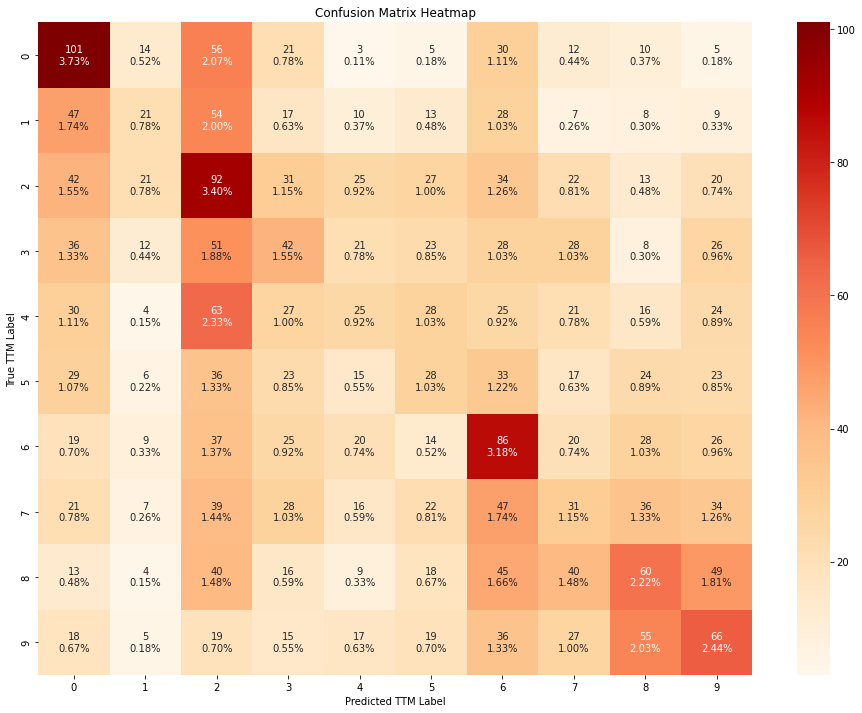

In [46]:
train_evaluate_classifier(
    xgbc, X_train_scaled_pruned, y_train, X_test_scaled_pruned, y_test
)

From the confusion matrices above, we can conclude that the models perform slightly better when trained using all the features, instead of using only the RFE-pruned subset. 

## Create sklearn Pipeline

Here, we will create an sklearn pipeline consisting of 2 steps, scaling of the input features and the classifier itself. We will then save this Pipeline as a `model.joblib` file on S3 for serving the model pipeline using the Seldon Sklearn Server.

In [47]:
pipe = Pipeline(
    steps=[
        ("extract_features", raw_data_processor),
        ("scale", scaler),
        ("rf", selected_model),
    ]
)

## Write Model to S3

In [49]:
key = "ai4ci/github-pr-ttm/model"
filename = "model.joblib"
s3_resource = boto3.resource(
    "s3",
    endpoint_url=s3_endpoint_url,
    aws_access_key_id=s3_access_key,
    aws_secret_access_key=s3_secret_key,
)

with tempfile.TemporaryFile() as fp:
    joblib.dump(pipe, fp)
    fp.seek(0)
    s3_obj = s3_resource.Object(s3_bucket, f"{key}/{filename}")
    s3_obj.put(Body=fp.read())

In [50]:
## Sanity Check
buffer = BytesIO()
s3_object = s3_resource.Object(s3_bucket, f"{key}/{filename}")
s3_object.download_fileobj(buffer)
model = joblib.load(buffer)
model

Pipeline(steps=[('extract_features',
                 ColumnTransformer(transformers=[('pr_size',
                                                  OrdinalEncoder(categories=[['XS',
                                                                              'S',
                                                                              'M',
                                                                              'L',
                                                                              'XL',
                                                                              'XXL']]),
                                                  ['size']),
                                                 ('is_reviewer',
                                                  IsUserPrivTransformer(priv='reviewers'),
                                                  ['created_by']),
                                                 ('is_approver',
                                                

In [51]:
# take raw pr data and predict ttm classes
preds = model.predict(pr_df.reindex(X_test.index))
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.25      0.42      0.32       257
           1       0.15      0.07      0.10       214
           2       0.22      0.23      0.22       327
           3       0.15      0.12      0.13       275
           4       0.21      0.11      0.15       263
           5       0.13      0.10      0.11       234
           6       0.21      0.24      0.23       284
           7       0.13      0.11      0.12       281
           8       0.17      0.22      0.19       294
           9       0.21      0.28      0.24       277

    accuracy                           0.19      2706
   macro avg       0.18      0.19      0.18      2706
weighted avg       0.19      0.19      0.18      2706



## Conclusion

In this notebook, we explored various vanilla classifiers, namely, Naive Bayes, SVM, Random Forests, and XGBoost. The XGBoost classifier was able to predict the classes with a weighted average f1 score of 0.21 an accuracy of 22% when trained using all the available features. Also, all of the models perform better when trained using all available features than when trained using a top 20 features determined using RFE. 

Even though all models outperform the baseline (random guess), we believe there is still some room for improvement. Since the target variable of the github PR dataset is an ordinal variable, an ordinal classifier could perform better than the models trained in this notebook. We will explore this idea in a future notebook.

As the immediate next step, we will to deploy the best model from this notebook as an inference service using Seldon.